# Zadanie 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

np.random.seed(2137)

# Read data
header = pd.io.parsers.read_csv("dataset/breast-cancer.labels", header=None)
data_validate : pd.DataFrame = pd.io.parsers.read_csv("dataset/breast-cancer-validate.dat", header=None)
data_train : pd.DataFrame = pd.io.parsers.read_csv("dataset/breast-cancer-train.dat", header=None)

# Add headers for columns
data_validate.columns = header[0]
data_train.columns = header[0]


A_train = data_train.drop(labels=["patient ID", "Malignant/Benign"], axis="columns").to_numpy()
A_validate = data_validate.drop(labels=["patient ID", "Malignant/Benign"], axis="columns").to_numpy()


## Metoda najmniejszych kwadratów z laboratorium 2

In [2]:
B_train = np.where(data_train["Malignant/Benign"] == "M", 1., 0.)

B_validate = np.where(data_validate["Malignant/Benign"] == "M", 1., 0.)

AT_train = np.transpose(A_train)

# Calculate weight vector for linear representation
w_lstsq = np.linalg.solve(np.matmul(AT_train, A_train), np.matmul(AT_train, B_train))

## Spadek wzdłuż gradientu

In [3]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

def xentropy(s, t):
    return -np.mean(t*np.log(s) + (1-t)*np.log(1-s))  # binary crossentropy

def grad_xentropy(X, S, T):
    return np.dot(np.transpose(X), S - T) / S.shape[0] #per input

def grd_fit(W, X, t, lr, steps):
    for i in range(steps):
        s = sigmoid(np.dot(X, W))
        
        loss = xentropy(s, t)
        if i % 500 == 0:
            print(f"Krok {i}: funkcja kosztu {loss:.4f}")
        
        W = W - lr * grad_xentropy(X, s, t)

    return W

In [4]:
STEPS = 50000

scaler = StandardScaler()

A_train_scaled = scaler.fit_transform(A_train)
A_validate_scaled = scaler.transform(A_validate)

# Dodanie biasu:
X_train = np.hstack([A_train_scaled, np.ones((A_train_scaled.shape[0], 1))])
X_validate = np.hstack([A_validate_scaled, np.ones((A_validate_scaled.shape[0], 1))])

# Inicjalizacja wag (wektor, bo 1 neuron wyjściowy):
W0 = np.random.randn(X_train.shape[1])

# learning rate
eigvals = np.linalg.eigvals(X_train.T @ X_train)
lambda_max = np.max(eigvals.real)
lambda_min = np.min(eigvals.real)
lr = 2 / (lambda_max+lambda_min)
print(f"Learning rate: {lr}")


W = grd_fit(W0, X_train, B_train, lr, STEPS)


Learning rate: 0.0005120333818459334
Krok 0: funkcja kosztu 2.2342
Krok 500: funkcja kosztu 1.8245
Krok 1000: funkcja kosztu 1.5387
Krok 1500: funkcja kosztu 1.3337
Krok 2000: funkcja kosztu 1.1770
Krok 2500: funkcja kosztu 1.0520
Krok 3000: funkcja kosztu 0.9494
Krok 3500: funkcja kosztu 0.8640
Krok 4000: funkcja kosztu 0.7922
Krok 4500: funkcja kosztu 0.7317
Krok 5000: funkcja kosztu 0.6809
Krok 5500: funkcja kosztu 0.6383
Krok 6000: funkcja kosztu 0.6022
Krok 6500: funkcja kosztu 0.5711
Krok 7000: funkcja kosztu 0.5439
Krok 7500: funkcja kosztu 0.5199
Krok 8000: funkcja kosztu 0.4984
Krok 8500: funkcja kosztu 0.4791
Krok 9000: funkcja kosztu 0.4615
Krok 9500: funkcja kosztu 0.4456
Krok 10000: funkcja kosztu 0.4309
Krok 10500: funkcja kosztu 0.4175
Krok 11000: funkcja kosztu 0.4051
Krok 11500: funkcja kosztu 0.3936
Krok 12000: funkcja kosztu 0.3828
Krok 12500: funkcja kosztu 0.3726
Krok 13000: funkcja kosztu 0.3630
Krok 13500: funkcja kosztu 0.3539
Krok 14000: funkcja kosztu 0.3452
K

In [5]:
def calc_accuracy(x, w, y):
    p = sigmoid(np.dot(x, w)) >= 0.5
    return np.mean(p == y)

def calc_accuracy_sqrs(x, w, y):
    p = np.dot(x, w) >= 0.5
    return np.mean(p == y)


print(f"Dokładność metody spadku wzdłuż gradientu: {100*calc_accuracy(X_validate, W, B_validate): .2f}%")
print(f"Dokładność metody najmniejszych kwadratów: {100*calc_accuracy_sqrs(A_validate, w_lstsq, B_validate): .2f}%")


Dokładność metody spadku wzdłuż gradientu:  94.23%
Dokładność metody najmniejszych kwadratów:  97.31%


# Zadanie 2

In [6]:
LAMBDA1 = 1
LAMBDA2 = 1
ITERATIONS = 400
eps = 10**-13
x0 = [0., 0.]
xn = [20., 20.]

R = np.random.uniform(0, 20, (50, 2))

def cost_function(X):
    term1 = term2 = 0.
    for i in range(np.shape(X)[0]):
        for j in range(np.shape(R)[0]):
            term1 += 1. / (eps + np.square(np.linalg.norm(X[i] - R[j])))

    term1 *= LAMBDA1

    for i in range(np.shape(X)[0]-1):
        term2 += np.square(np.linalg.norm(X[i] - X[i+1]))
    
    term2 *= LAMBDA2

    return term1 + term2

def gradient(X):
    grd = np.zeros_like(X)

    for i in range(1, np.shape(X)[0]-1):
        for j in range(np.shape(R)[0]):
            grd[i] += (X[i]-R[j]) / np.square(eps + np.square(np.linalg.norm(X[i] - R[j])))

        grd[i] *= -2 * LAMBDA1
        grd[i] += 2*(-X[i-1] + 2*X[i] -X[i+1])

    return grd


In [7]:
from scipy.optimize import golden

def grad_line_search(X: np.ndarray) -> tuple[np.ndarray, list[float]]:
    A = np.copy(X)
    cost_values = []
    for i in range(ITERATIONS):
        cost_values.append(cost_function(A))  
        
        grd = gradient(A)
        lr = golden(lambda a: cost_function(A - a * grd))
        A = A - lr * grd
        if np.linalg.norm(lr * grd) < eps:
            break
        
    return A, cost_values


In [8]:
# funkcja do wizulizacji ścieżki robota X i położenia przeszkód R
def plot_path(X, R,  name, plot_coordinates = False):
    plt.figure(figsize = (10, 10))
    plt.plot(X[:, 0], X[:, 1], marker = 'o', linestyle = '-', color = 'b', label = 'Ścieżka robota')
    plt.scatter(X[:, 0], X[:, 1], color = 'b')
    plt.scatter(R[:, 0], R[:, 1], color = 'r', marker = 'x', label = 'Przeszkody')

    # dodanie współrzędnych punktów ścieżki oraz przeszkód do wykresu
    if plot_coordinates:
        for i, (x, y) in enumerate(X):
                plt.text(x, y, f'({x:.1f}, {y:.1f})', fontsize = 9, ha = 'right')

        for i, (x, y) in enumerate(R):
            plt.text(x, y, f'({x:.1f}, {y:.1f})', fontsize = 9, ha = 'left')

    # numeracja punktów, żeby można było odtworzyć kolejność kroków robota
    for i, (x, y) in enumerate(X):
            plt.text(x, y, f'({i})', fontsize = 9, ha = 'right')

    plt.ylim(-1, 21)
    plt.grid(True)
    plt.legend()

    plt.xlabel('Współrzędna X')
    plt.ylabel('Współrzędna Y')
    plt.title('Przeszkody i ścieżka robota ' + name)

    plt.show()

In [9]:
X0 = []
results = []
costs = []
for i in range(5):
    X0.append(np.vstack((x0, np.random.uniform(0, 20, (19, 2)), xn)))

    optimized, c = grad_line_search(X0[i])
    results.append(optimized)
    costs.append(c)

    print(f"---------------- Przykład {i+1} ----------------")
    print(f"Wartość funkcji kosztu dla wejściowych punktów: {c[0]: .03f}")
    print(f"Wartość funkcji kosztu dla zoptymalizowanych punktów: {cost_function(results[i]): .03f}")

---------------- Przykład 1 ----------------
Wartość funkcji kosztu dla wejściowych punktów:  3259.368
Wartość funkcji kosztu dla zoptymalizowanych punktów:  85.486
---------------- Przykład 2 ----------------
Wartość funkcji kosztu dla wejściowych punktów:  4131.620
Wartość funkcji kosztu dla zoptymalizowanych punktów:  89.185
---------------- Przykład 3 ----------------
Wartość funkcji kosztu dla wejściowych punktów:  2186.461
Wartość funkcji kosztu dla zoptymalizowanych punktów:  79.948
---------------- Przykład 4 ----------------
Wartość funkcji kosztu dla wejściowych punktów:  2939.993
Wartość funkcji kosztu dla zoptymalizowanych punktów:  83.871
---------------- Przykład 5 ----------------
Wartość funkcji kosztu dla wejściowych punktów:  2628.394
Wartość funkcji kosztu dla zoptymalizowanych punktów:  83.922


## Wizualizacja przykładowej ścieżki robota przed i po optymalizacji

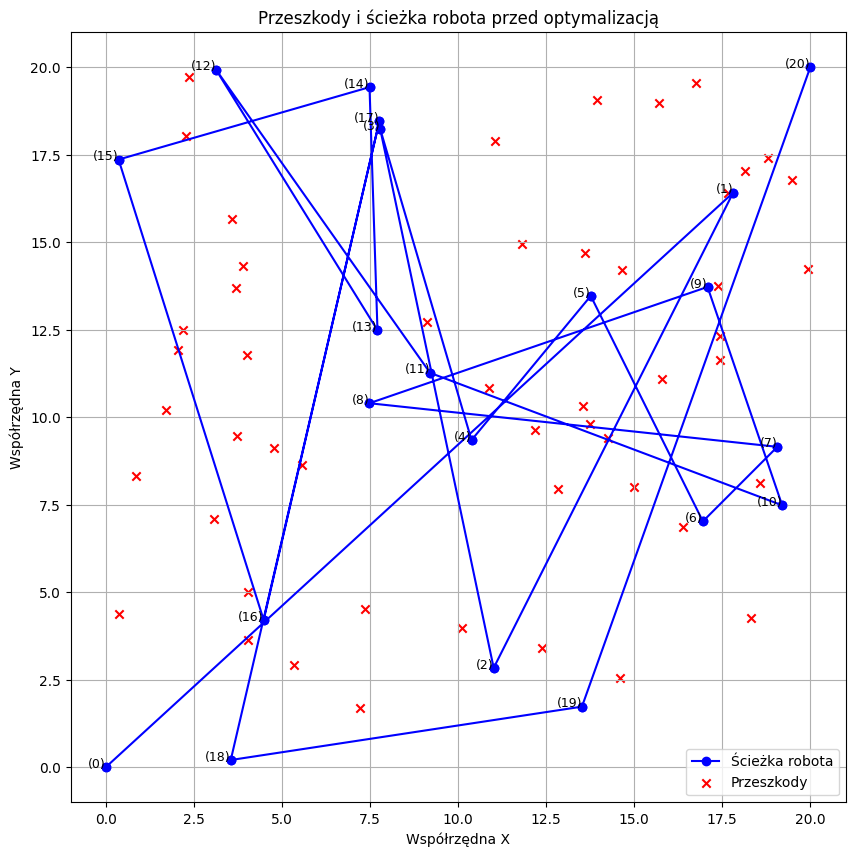

In [10]:
plot_path(X0[0], R, "przed optymalizacją")

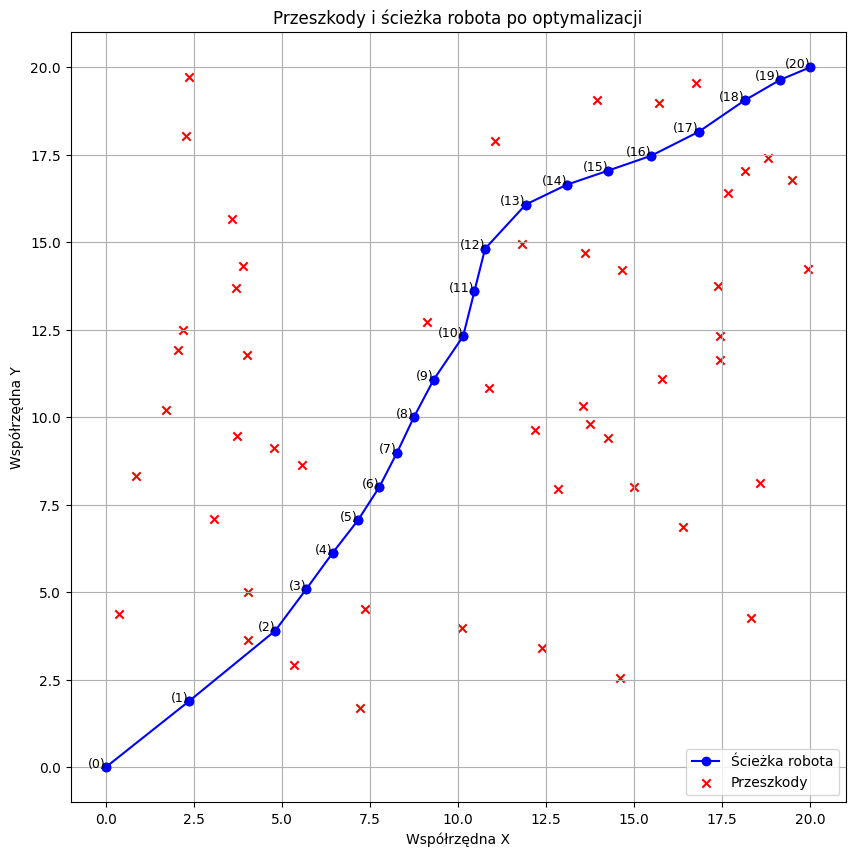

In [11]:
plot_path(results[0], R, "po optymalizacji")

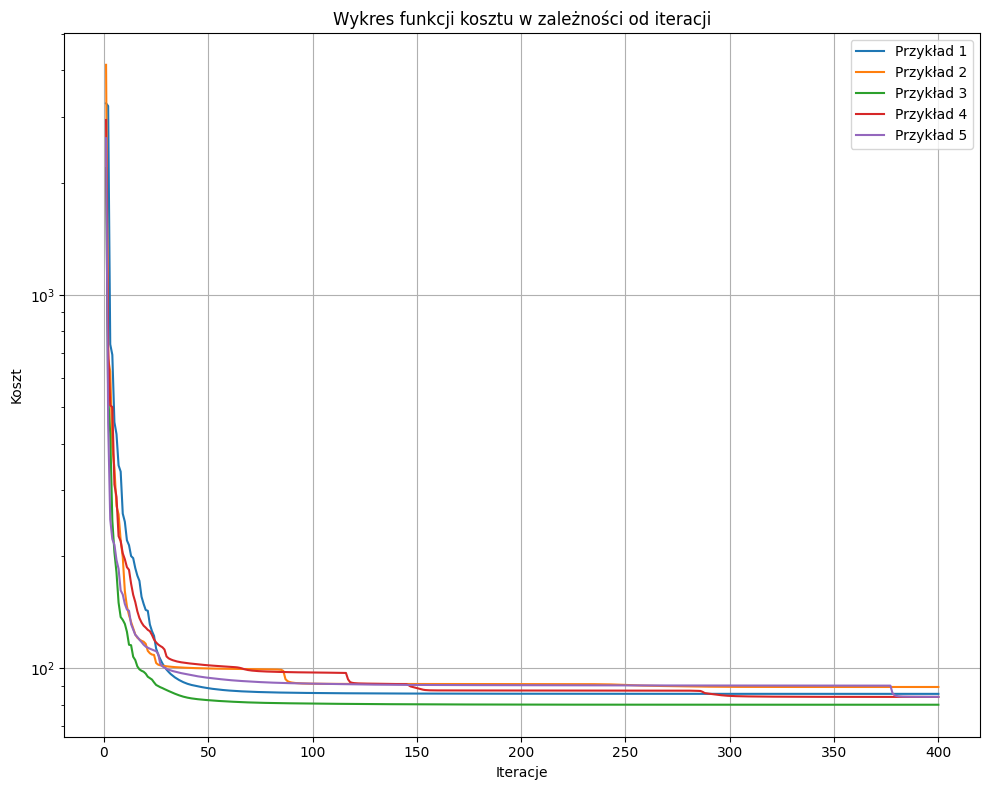

In [17]:
def plot_cost_function(costs_list):
    plt.figure(figsize = (10, 8))

    for costs in costs_list:
        iterations = range(1, len(costs) + 1)
        plt.plot(iterations, costs, label = f'Przykład {costs_list.index(costs) + 1}')

    plt.title('Wykres funkcji kosztu w zależności od iteracji')
    plt.xlabel('Iteracje')
    plt.ylabel('Koszt')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.show()

plot_cost_function(costs)

## Wizualizacja pozostałych ścieżek

In [15]:
def plot_two_paths(X1, X2, R, plot_coordinates=False):
    """
    Visualizes two robot paths (X1, X2) and obstacles (R) in two subplots.

    Args:
        X1 (numpy.ndarray): Coordinates of the first robot's path.
        X2 (numpy.ndarray): Coordinates of the second robot's path.
        R (numpy.ndarray): Coordinates of the obstacles.
        name1 (str): Title for the first subplot.
        name2 (str): Title for the second subplot.
        plot_coordinates (bool): If True, displays coordinates of points on the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8)) # Create 1 row, 2 columns of subplots

    # --- Plot for the first path (X1) ---
    axes[0].plot(X1[:, 0], X1[:, 1], marker='o', linestyle='-', color='b', label='Ścieżka robota')
    axes[0].scatter(X1[:, 0], X1[:, 1], color='b')
    axes[0].scatter(R[:, 0], R[:, 1], color='r', marker='x', label='Przeszkody')

    if plot_coordinates:
        for i, (x, y) in enumerate(X1):
            axes[0].text(x, y, f'({x:.1f}, {y:.1f})', fontsize=9, ha='right')
        for i, (x, y) in enumerate(R):
            axes[0].text(x, y, f'({x:.1f}, {y:.1f})', fontsize=9, ha='left')

    for i, (x, y) in enumerate(X1):
        axes[0].text(x, y, f'({i})', fontsize=9, ha='right')

    axes[0].set_ylim(-1, 21)
    axes[0].grid(True)
    axes[0].legend()
    axes[0].set_xlabel('Współrzędna X')
    axes[0].set_ylabel('Współrzędna Y')
    axes[0].set_title('Przed optymalizacją')

    # --- Plot for the second path (X2) ---
    axes[1].plot(X2[:, 0], X2[:, 1], marker='o', linestyle='-', color='b', label='Ścieżka robota')
    axes[1].scatter(X2[:, 0], X2[:, 1], color='b')
    axes[1].scatter(R[:, 0], R[:, 1], color='r', marker='x', label='Przeszkody')

    if plot_coordinates:
        for i, (x, y) in enumerate(X2):
            axes[1].text(x, y, f'({x:.1f}, {y:.1f})', fontsize=9, ha='right')
        for i, (x, y) in enumerate(R):
            axes[1].text(x, y, f'({x:.1f}, {y:.1f})', fontsize=9, ha='left')

    for i, (x, y) in enumerate(X2):
        axes[1].text(x, y, f'({i})', fontsize=9, ha='right')

    axes[1].set_ylim(-1, 21)
    axes[1].grid(True)
    axes[1].legend()
    axes[1].set_xlabel('Współrzędna X')
    axes[1].set_ylabel('Współrzędna Y')
    axes[1].set_title('Po optymalizacji')

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()

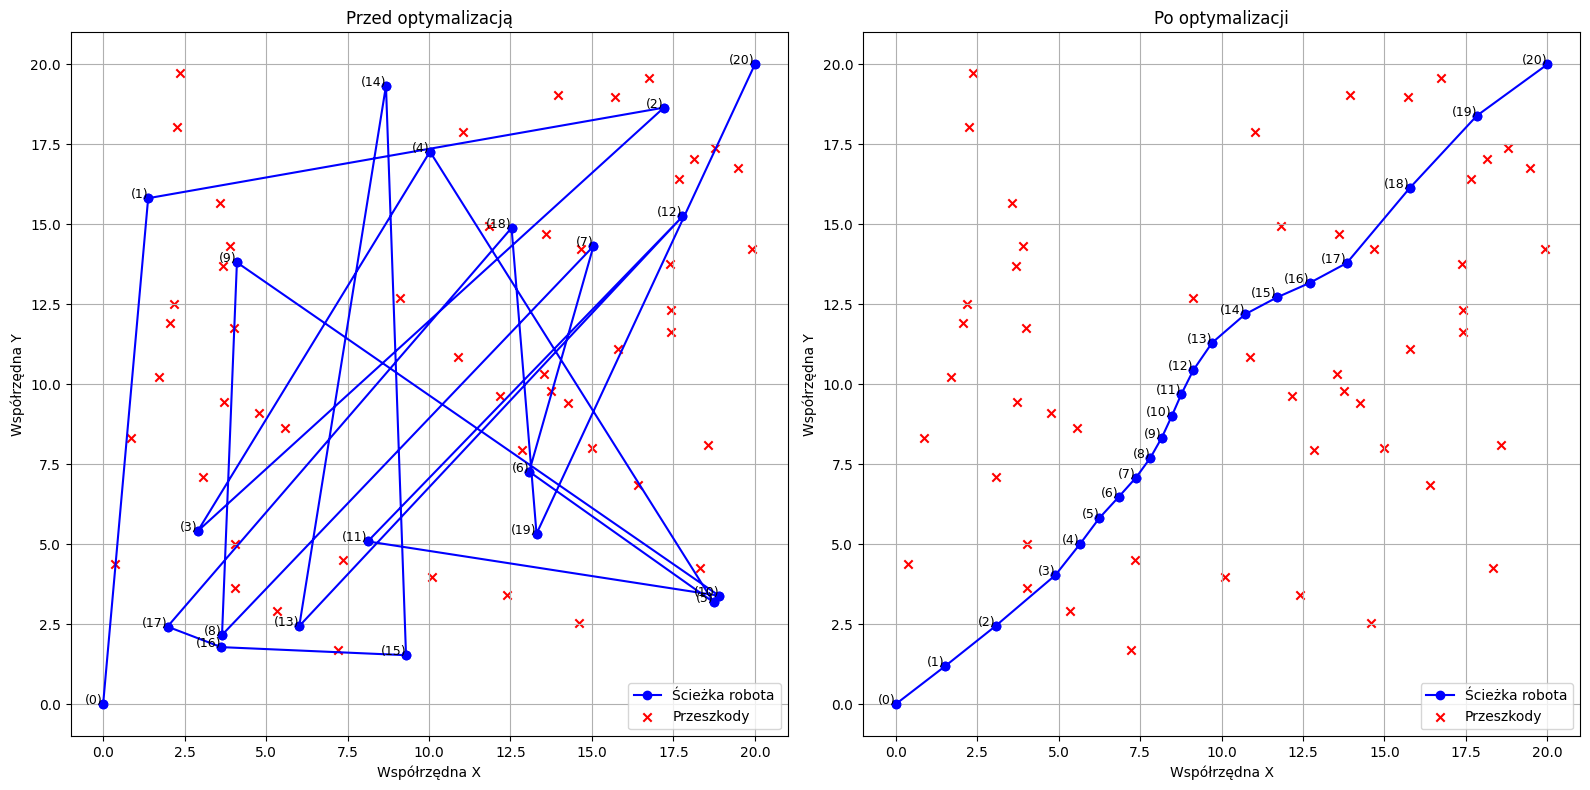

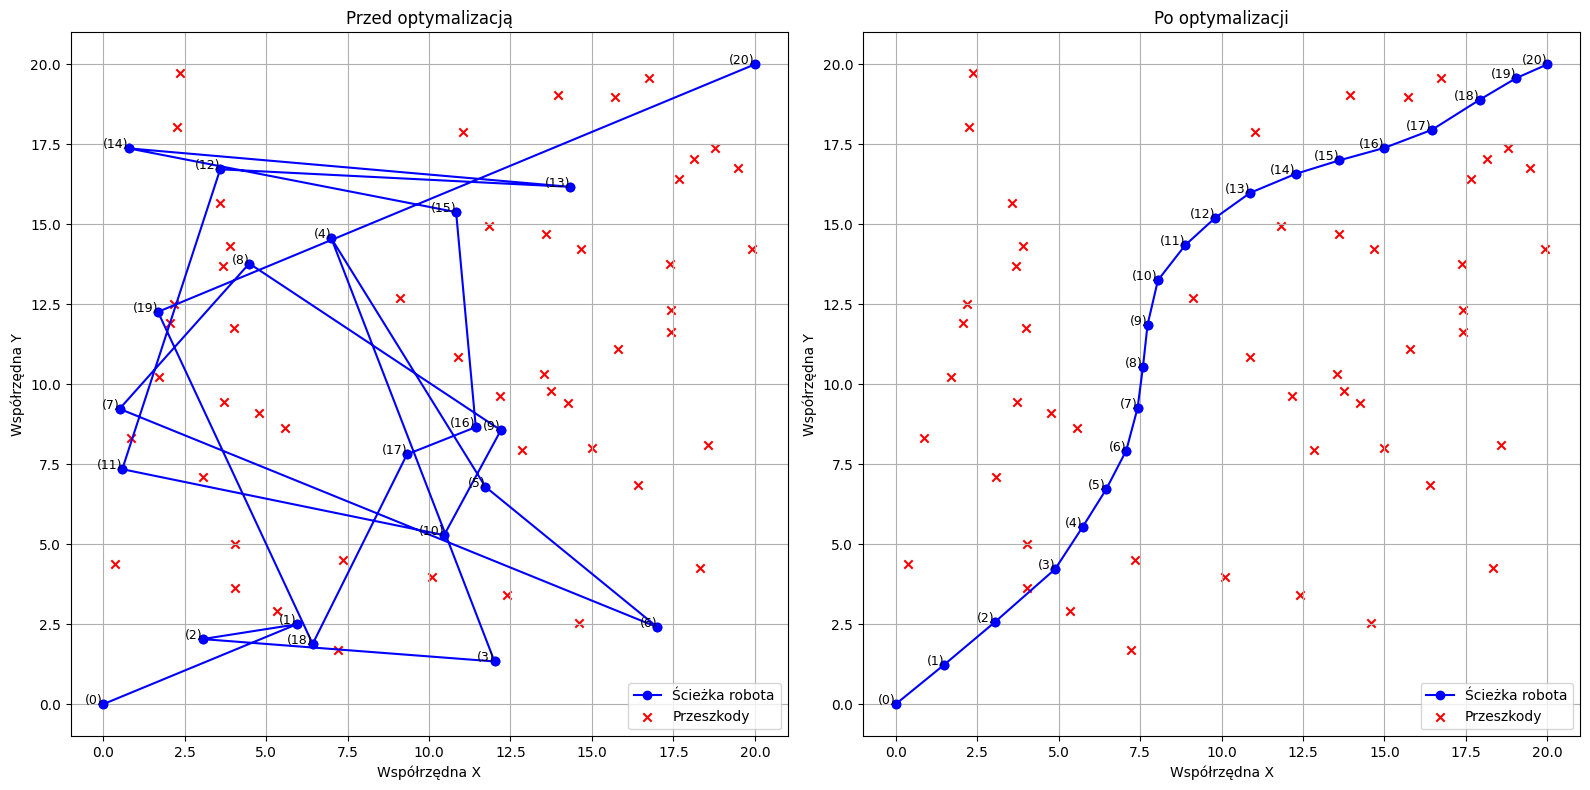

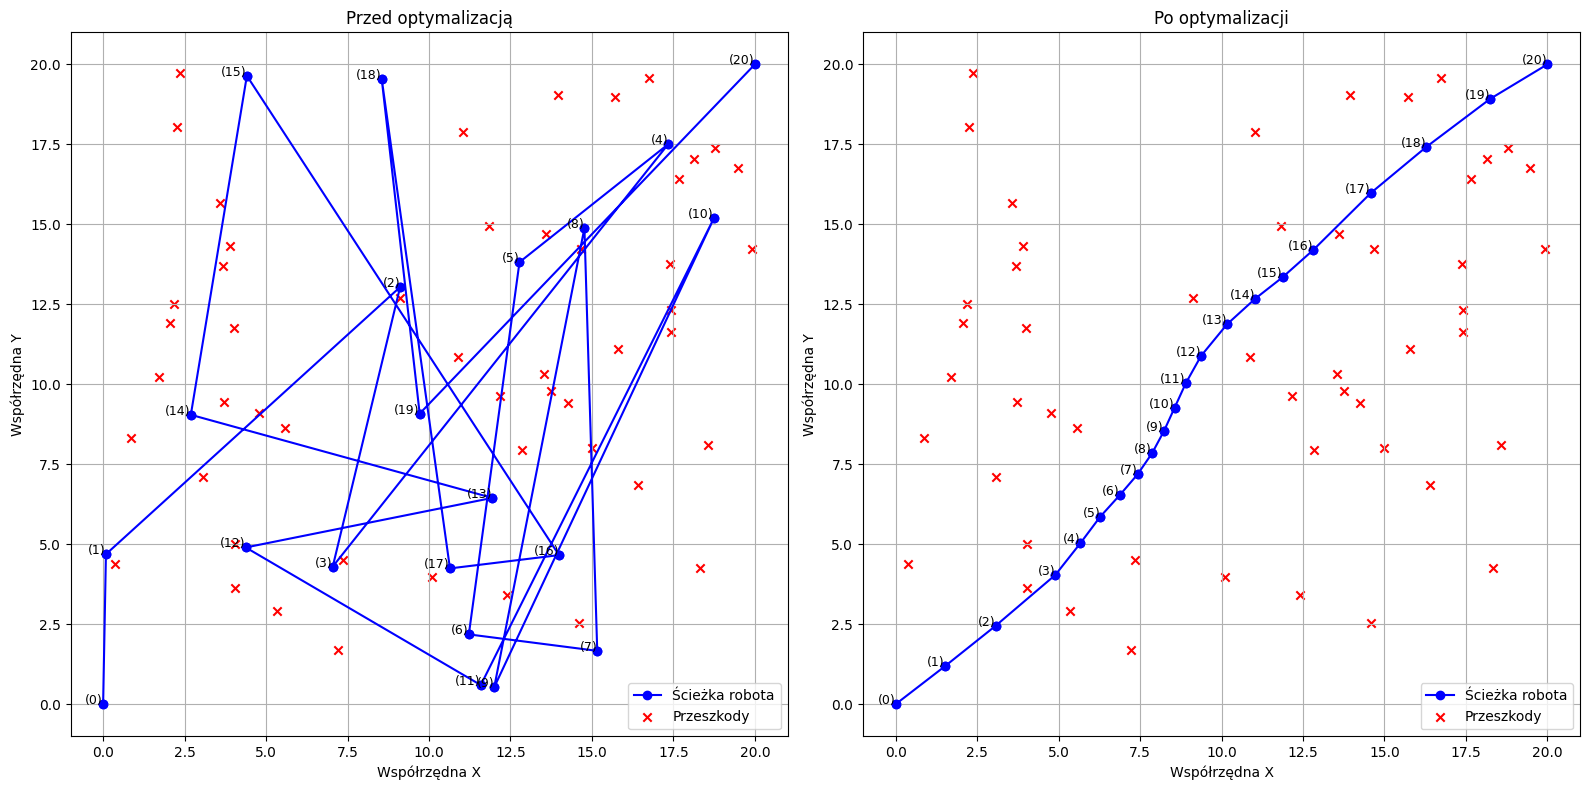

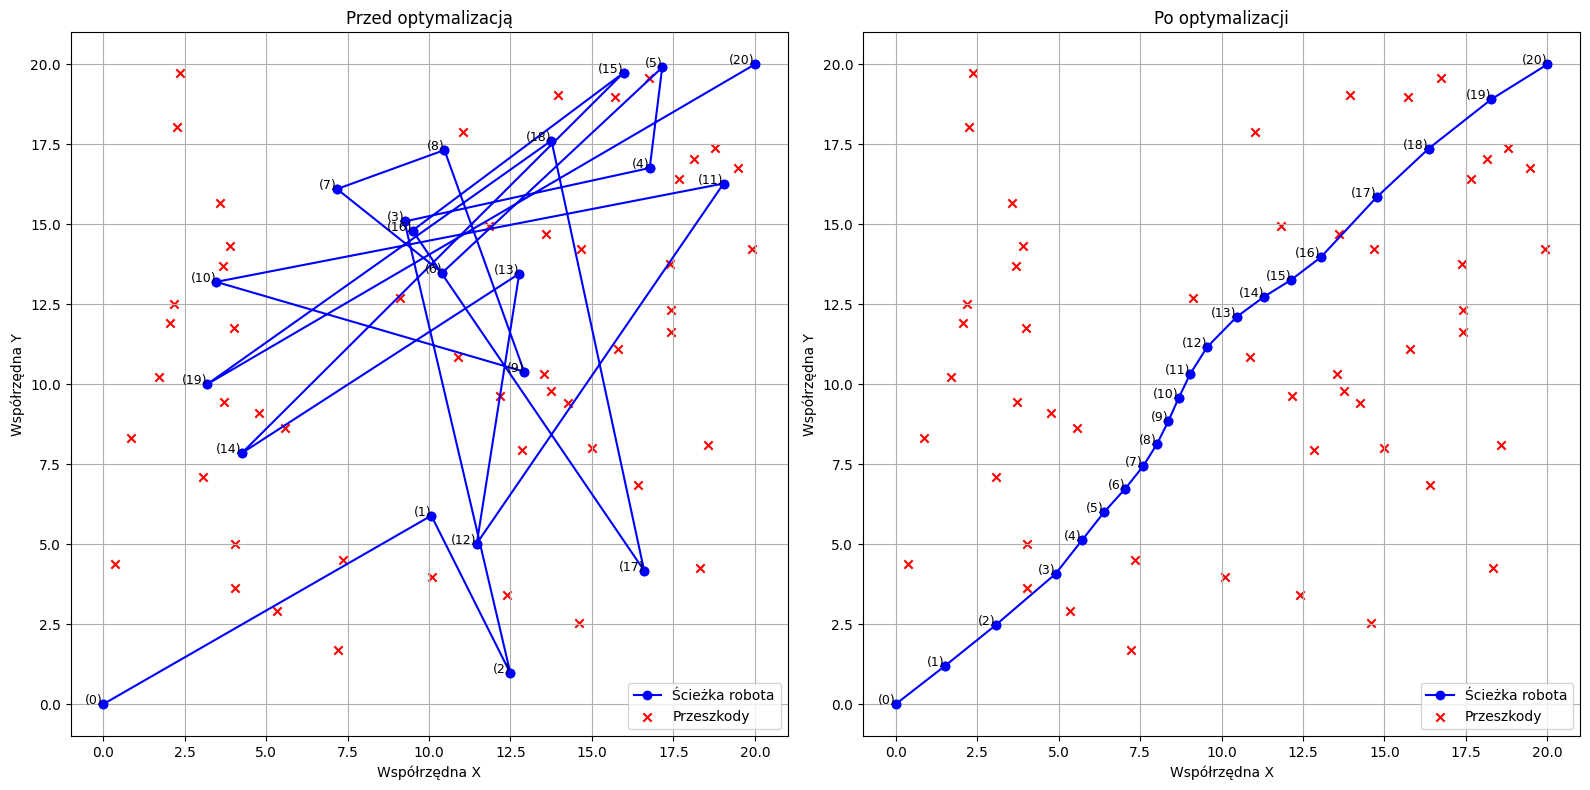

In [16]:
plot_two_paths(X0[1], results[1], R, False)
plot_two_paths(X0[2], results[2], R, False)
plot_two_paths(X0[3], results[3], R, False)
plot_two_paths(X0[4], results[4], R, False)